# Building a Custom Metric Function 

Developing machine learning models are often (and should be) based on iterative hypothesis testing.
Typically, you get some data and labels and train your first model.
Then, you realise that it's performing worse than you had hoped.

Now, you starting hypothesizing about what might be wrong.
Perhaps you suspect that the color of each object matters for your model.
So you define a hypothesis like:

> Object colors have a significant impact on my model performance

Traditionally, the next thing you would do is to write a script for filtering, ordering, and visualising your validation data as a function of the object colors.
Something like this:

<details open="1" style="margin-bottom: 2rem; padding: .5rem 1rem; border: solid 1px black;">
<summary style="cursor: pointer; font-weight: 600; margin-bottom: 0.5rem">Codeblock that you can safely hide</summary>

```python
# DISCLAIMER: This is just to show how much code you need to write to test your hypothesis
#             It's not meant to work or to be copied in any way!

from functools import partial

color_ordering = [] 
acc = [] 

def get_colors_for_object(image, object):
    # Some code to determine colors
    return color_metric

for batch in validation_loader:
    for image, labels in batch:
        predictions = my_model(images)

        acc += ... # some hard to write code for match predictions with labels
        color_ordering += list(map(partial(get_colors_for_object, image=image), predictions))
        
color_ordering = np.array(color_ordering)
sorting = np.argsort(color_ordering)
color_ordering = color_ordering[ordering]
acc = np.array(color_ordering)[ordering] 

# LOONG plotting code section for displaying samples, plots, and what not.
# ...
# ...
# ...
```

   
</details>

When you're finally done writing code and plotting things, hopefully you can reach a conclusion regarding your hypothesis.
When you reach this point, you will have probably have many more hypothesis that you want to test and eventually also more models to evaluate.
Do we need to mention how painful it will be to extend the code above with new use cases, plots, etc.?
What if you, for example, wanted to know the same thing, not only for your predictions but also for the labels? What about false negatives? .. and so on.

Encord Active solves this problem with a couple of points in focus:

1. **Reusability:** You define your metric function once and then you can reuse again and again.
2. **Isolation of functionality:** Since the metric function is defined in isolation from other metrics, you won't accidentally introduce errors in other functions, plots, etc.
3. **Iteration speed:** we've made it easy to implement your own metric function such that you can iterate faster.
4. **It's built from experience:** We have felt this pain many times and we have seen many of the common hypothesis that come up. We're building Encord Active to deel with all these common scenarios while being extensible enough to be tailored to your custom use case.

Other points that we want to highlight is that 

1. Encord Active ships with a bunch of [pre-defined metrics](https://encord-active-docs.web.app/category/metrics) that will automatically be run on your data when you import it.
2. When you've [imported your model predictions](), Encord Active will automatically identify those metrics that are more important for your model performance.

This tutorial will take you through how to write such metric functions and use them with Encord Active.

# Defining a `Metric` sub-class

Here, we'll give some detailed information on how a quality metric is defined.

> **🌟 Info**: If you don't like abstract talk, you can skip directly to [the example below](#concrete-example) to see how to implement a specific metric.

Below we've listed the entire stub for defining a metric. Following right after is a breakdown of the different components.

In [ ]:
from encord_active.lib.common.iterator import Iterator
from encord_active.lib.metrics.metric import AnnotationType, DataType, MetricType, Metric
from encord_active.lib.metrics.writer import CSVMetricWriter

class ExampleMetric(Metric):
    TITLE = "[the-name-of-your-metric]"
    METRIC_TYPE = MetricType.HEURISTIC
    DATA_TYPE = DataType.IMAGE
    ANNOTATION_TYPE = [AnnotationType.OBJECT.BOUNDING_BOX, AnnotationType.OBJECT.POLYGON]
    SHORT_DESCRIPTION = "A short description of your metric."
    LONG_DESCRIPTION = "A longer and more detailed description. " \
                       "I can use Markdown to _format_ the text."

    def execute(self, iterator: Iterator, writer: CSVMetricWriter):
        valid_annotation_types = {annotation_type.value for annotation_type in self.ANNOTATION_TYPE}

        for data_unit, img_pth in iterator.iterate(desc="Progress bar description"):
            # Frame level score (data quality)
            writer.write(1337, description="Your description for the frame [can be omitted]")
            
            for obj in data_unit["labels"].get("objects", []):
                # Label (object/classification) level score (label / model prediction quality)
                if not obj["shape"] in valid_annotation_types:
                    continue

                # Do your thing (inference)
                # ...
                # Then
                writer.write(42, labels=obj, description="Your description of the score [can be omitted]")

Executing a metric on a project follows this structure:

In [ ]:
from pathlib import Path
from encord_active.lib.metrics.execute import execute_metric
from encord_active.lib.model_predictions.iterator import PredictionIterator

target = Path("/path/to/your/project")

execute_metric(ExampleMetric(), data_dir=target)  # for labels
execute_metric(ExampleMetric(), data_dir=target, iterator_cls=PredictionIterator)  # for predictions (only makes sense to do if your metric applies to labels)

# Wrap this entire code block in a 
# `if __name__ == "__main__":`
# and put it in the bottom of your metric file if you want to be able to run
# python your_metric.py

TODO write out what the different components are!

<a id='concrete-example'></a>
## Concrete Walk through Example


In this example, we'll continue the idea of testing the model performance as a function of the color of individual objects.

To get started, let's have a look at the [HSV color space](https://en.wikipedia.org/wiki/HSL_and_HSV), which is great for color filtering.
The following code indicate how different Hue (the H from HSV) values correspond to different colors.

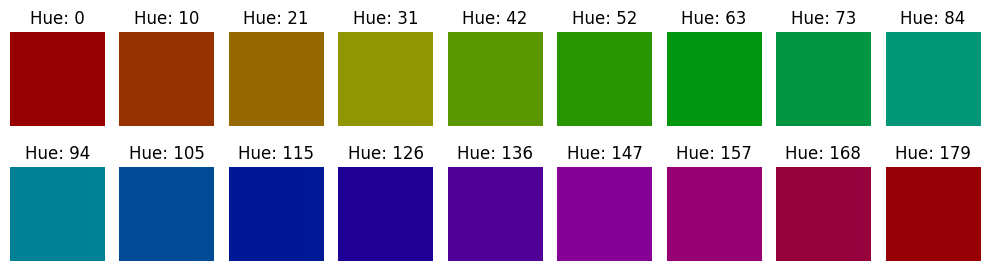

In [66]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def get_img(H: int):
    """
    Make image with specific Hue color and convert it to RGB for plotting.
    """
    img =  np.ones((20, 20, 3), dtype=np.uint8)
    img[..., 0] = H
    img[..., 1] = 255
    img[..., 2] = 150 
    return cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

# Hue ranges from 0 to 180 and "wraps" around.
hues = np.linspace(0, 179, 18, dtype=np.uint8)
imgs = [get_img(i) for i in hues]

fig, ax = plt.subplots(2, 9, figsize=(10, 3))
ax = ax.reshape(-1)

# Plot the colors
for  img, a, h in zip(imgs, ax, hues):
    a.set_title(f"Hue: {h}")
    a.axis('off')
    a.imshow(img)

fig.tight_layout()
plt.show()

Note how the first and the last images are very close in terms of color, but has a very different hue value. 
This is because of the "circular" / "wrap-around" nature of the color space. 
Let's account for that by computing a value, which is similar for similar colors.

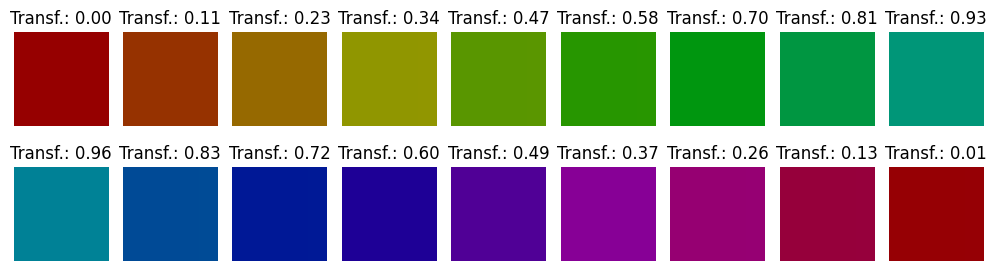

In [67]:
def transform_hue(H: int):
    return (90 - np.abs(h - 90)) / 90

# Plotting
fig, ax = plt.subplots(2, 9, figsize=(10, 3))
ax = ax.reshape(-1)

for img, a, h in zip(imgs, ax, hues):
    t = transform_hue(h)
    a.set_title(f"Transf.: {t:.2f}")
    a.imshow(img)
    a.axis('off')
fig.tight_layout()

Alright, this looks better.
The transformed value is a better candidate for our metric function.

Next, we'll 

In [ ]:
%%file metric.py
from collections import defaultdict

import numpy as np
from encord_active.lib.common import utils
from encord_active.lib.common.iterator import Iterator
from encord_active.lib.metrics.metric import AnnotationType, DataType, Metric, MetricType
from encord_active.lib.metrics.writer import CSVMetricWriter
from loguru import logger

logger = logger.opt(colors=True)


class InstanceDeviation(Metric):
    TITLE = "Instance Deviation"
    METRIC_TYPE = MetricType.HEURISTIC
    DATA_TYPE = DataType.IMAGE
    ANNOTATION_TYPE = [AnnotationType.OBJECT.BOUNDING_BOX, AnnotationType.OBJECT.POLYGON]
    SHORT_DESCRIPTION = "Find deviation of an object's instance comparing it to its other instances."
    LONG_DESCRIPTION = r"""Find deviation of an object's instance comparing it to its other instances.  
Deviation is calculated using center of the objects.
"""

    def test(self, iterator: Iterator, writer: CSVMetricWriter):
        valid_annotation_types = {annotation_type.value for annotation_type in self.ANNOTATION_TYPE}

        object_hash_to_centroids = defaultdict(dict)

        # Separate objects' instances (same objectHash [aka track id] means same object instance)
        for data_unit, img_pth in iterator.iterate(desc="Custom progress description"):
            frame_id = data_unit["data_sequence"]
            for obj in data_unit["labels"].get("objects", []):
                # Only analyse objects with valid shapes (bounding boxes and polygons)
                if not obj["shape"] in valid_annotation_types:
                    continue
                obj_hash = obj["objectHash"]
                # Check out 'utils.get_object_coordinates' to learn more about Encord's object coordinates extraction
                poly = utils.get_polygon(obj)
                if poly is not None:
                    obj_centroid = tuple(poly.centroid.coords)
                    object_hash_to_centroids[obj_hash][frame_id] = obj_centroid

        # Calculate deviation
        object_hash_to_centroid_mean = defaultdict(float)
        for obj_hash, centroids in object_hash_to_centroids.items():
            centroid_mean = sum(centroids.values(), np.array([0, 0])) / len(centroids)
            object_hash_to_centroid_mean[obj_hash] = centroid_mean

        # Evaluate deviation on each object instance and save it
        for data_unit, img_pth in iterator.iterate(desc="Custom progress description"):
            frame_id = data_unit["data_sequence"]
            for obj in data_unit["labels"].get("objects", []):
                # Only analyse objects with valid shapes (bounding boxes and polygons)
                if not obj["shape"] in valid_annotation_types:
                    continue
                obj_hash = obj["objectHash"]
                if frame_id in object_hash_to_centroids[obj_hash].keys():
                    obj_centroid = object_hash_to_centroids[obj_hash][frame_id]
                    obj_score = np.linalg.norm(obj_centroid - object_hash_to_centroid_mean[obj_hash])
                    writer.write(obj_score, labels=obj)

if __name__ == "__main__":
    import sys
    from pathlib import Path

    from encord_active.lib.metric.execute import perform_test

    path = sys.argv[1]
    perform_test(InstanceDeviation(), data_dir=Path(path), use_cache_only=True)

Writing metric.py


## Download a prebuilt project

In [ ]:
project_name = "[open-source]-covid-19-segmentations"

!encord-active config set projects_dir '/content/.'
!encord-active download --project-name $project_name

2022-12-09 10:55:28.810 INFO    matplotlib.font_manager: generated new fontManager
Traceback (most recent call last):
  File "/usr/local/bin/encord-active", line 5, in <module>
    from encord_active.app.main import cli
  File "/usr/local/lib/python3.9/dist-packages/encord_active/app/main.py", line 18, in <module>
    from encord_active.lib.coco.importer import CocoImporter
  File "/usr/local/lib/python3.9/dist-packages/encord_active/lib/coco/importer.py", line 19, in <module>
    from encord_active.lib.coco.parsers import (
  File "/usr/local/lib/python3.9/dist-packages/encord_active/lib/coco/parsers.py", line 11, in <module>
    from encord_active.lib.coco.utils import annToMask
  File "/usr/local/lib/python3.9/dist-packages/encord_active/lib/coco/utils.py", line 6, in <module>
    from pycocotools.mask import decode, frPyObjects, merge
ModuleNotFoundError: No module named 'pycocotools'
Traceback (most recent call last):
  File "/usr/local/bin/encord-active", line 5, in <module>
    

## Run the custom metric on the project

In [ ]:
!python metric.py "/content/"$project_name

2022-12-09 10:55:33.283 | ERROR    | encord_active.lib.common.utils:fetch_project_info:21 - Couldn't find meta file for project
2022-12-09 10:55:33.283 | ERROR    | __main__:<module>:68 - An error has been caught in function '<module>', process 'MainProcess' (1055), thread 'MainThread' (140117598545792):
Traceback (most recent call last):

> File "/content/metric.py", line 68, in <module>
    perform_test(InstanceDeviation(), data_dir=Path(path), use_cache_only=True)
    │            │                             │    └ '/content/[open-source]-covid-19-segmentations'
    │            │                             └ <class 'pathlib.Path'>
    │            └ <class '__main__.InstanceDeviation'>
    └ <function perform_test at 0x7f6f8f35ea60>

  File "/usr/local/lib/python3.9/dist-packages/encord_active/lib/common/tester.py", line 42, in perform_test
    project = fetch_project_info(data_dir)
              │                  └ PosixPath('/content/[open-source]-covid-19-segmentations')
   